In [1]:
from collections import defaultdict
from itertools import cycle, product

from joblib import Parallel, delayed
from numba import jit, njit

import numpy as np

In [2]:
recipe_maps = [
    {"A": 8, "B": 4, "C": 4, "D": 8, "E": 10, "F": 16},
    {"A": 10, "B": 10, "C": 6, "D": 4},
    {"A": 3, "B": 3, "C": 4, "D": 3, "E": 3, "F": 2},
]

recipes = [np.asarray(list(m.values())) for m in recipe_maps]

batch_sizes = [25, 50, 100]
sample_size = 60000
lane_lock = 25

products_per_min = 250

In [3]:
def generate_sequential_batches(batch_size, recipe, sample_size):
    products = list(range(len(recipe)))
    totals = recipe
    num_of_batches = np.ceil(sample_size / batch_size).astype(int)

    counts = dict(sorted(zip(products, totals), key=lambda x: x[1], reverse=True))

    pattern = []
    while 0 < sum(counts.values()):
        for product in counts.keys():
            if 0 < counts[product]:
                pattern.append(product)
                counts[product] -= 1

    out = []
    for index, product in zip(range(num_of_batches), cycle(pattern)):
        out.extend([product] * batch_size)

    return np.array(out[:sample_size])


def generate_random_products(recipe, sample_size):
    products = list(range(len(recipe)))
    return np.random.choice(
        products,
        size=sample_size,
        p=[t / sum(recipe) for t in recipe],
    )

In [4]:
def create_infeed_types():
    infeeds = {}

    for i, batch_size in product(range(len(recipes)), batch_sizes):
        infeeds[(i, "sequential_batches", batch_size)] = generate_sequential_batches(
            batch_size, recipes[i], sample_size
        )

    for i, recipe in enumerate(recipes):
        infeeds[(i, "random_products", None)] = generate_random_products(
            recipe, sample_size
        )

    return infeeds


infeeds = create_infeed_types()

In [5]:
@njit
def simulate_fast(num_of_lanes, recipe, infeed, lane_lock):
    # rows are lanes
    # columns are products
    # n, m, k := num_of_lanes, num_of_products, num_of_iterations
    num_of_products = len(recipe)
    num_of_iterations = len(infeed)
    
    # n x m := state of each lane with product counts
    states = np.zeros((num_of_lanes, num_of_products), dtype=np.int32)
    
    # n x 1 := number of boxes produced per lane
    boxes = np.zeros(num_of_lanes, dtype=np.int32)
   
    # n x 1 := lock value of a lane
    locks = np.zeros(num_of_lanes, dtype=np.int32)
    
    # products that don't fit
    recirculation = 0
    
    # products that are packaged
    consumption = 0
    
    # n x k := boxes per iteration
    boxes_per_frame = np.zeros((num_of_lanes, num_of_iterations), dtype=np.int32)

    for i in range(infeed.size):

        product = infeed[i]

        consumed = False
        for neg_state, box_count, lane in sorted(
            zip(-states[:, product], boxes, range(num_of_lanes))
        ):

            # Lane is available to accept products
            lane_is_available = locks[lane] == 0

            # Lane has space to accept product
            product_fits = states[lane, product] < recipe[product]

            # Complete cases for 3 binary variables
            if not consumed and lane_is_available and product_fits:
                states[lane, product] += 1
                consumed = True

            elif not consumed and lane_is_available and not product_fits:
                continue

            elif not consumed and not lane_is_available and product_fits:
                locks[lane] -= 1

            elif not consumed and not lane_is_available and not product_fits:
                locks[lane] -= 1

            elif consumed and lane_is_available and product_fits:
                continue

            elif consumed and lane_is_available and not product_fits:
                continue

            elif consumed and not lane_is_available and product_fits:
                locks[lane] -= 1

            elif consumed and not lane_is_available and not product_fits:
                locks[lane] -= 1

        # record un-consumed products
        if not consumed:
            recirculation += 1

        # check if lanes are full; consume lane; cleanup lane
        # TODO := no need to check all lanes only the one that changed
        for lane in range(num_of_lanes):
            ready = True
            for product in range(num_of_products):
                ready &= states[lane, product] == recipe[product]

            if ready:
                # consume lane
                consumption += states[lane, :].sum()
                boxes[lane] += 1
                boxes_per_frame[lane, i] += 1
                
                # cleanup lane
                states[lane, :] = 0
                locks[lane] = lane_lock
                
    return recirculation, consumption, boxes, boxes_per_frame

In [6]:
num_of_lanes = 5
recipe = recipes[0]
infeed = infeeds[(0, "random_products", None)]

In [7]:
%timeit simulate_fast(num_of_lanes, recipe, infeed, lane_lock)

34.2 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
simulate_fast(num_of_lanes, recipe, infeed, lane_lock)

(3047,
 56850,
 array([228, 228, 227, 227, 227], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32))

In [9]:
def get_the_ys(xx, recipe, infeed, lane_lock=25):
    data = Parallel(n_jobs=4)(
        delayed(simulate_fast)(x, recipe, infeed, lane_lock)
        for x in xx
    )
    return [d[1] / len(infeed) for d in data]

In [10]:
xx = list(range(1, 25))

In [11]:
%timeit get_the_ys(xx, recipe, infeed)

344 ms ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


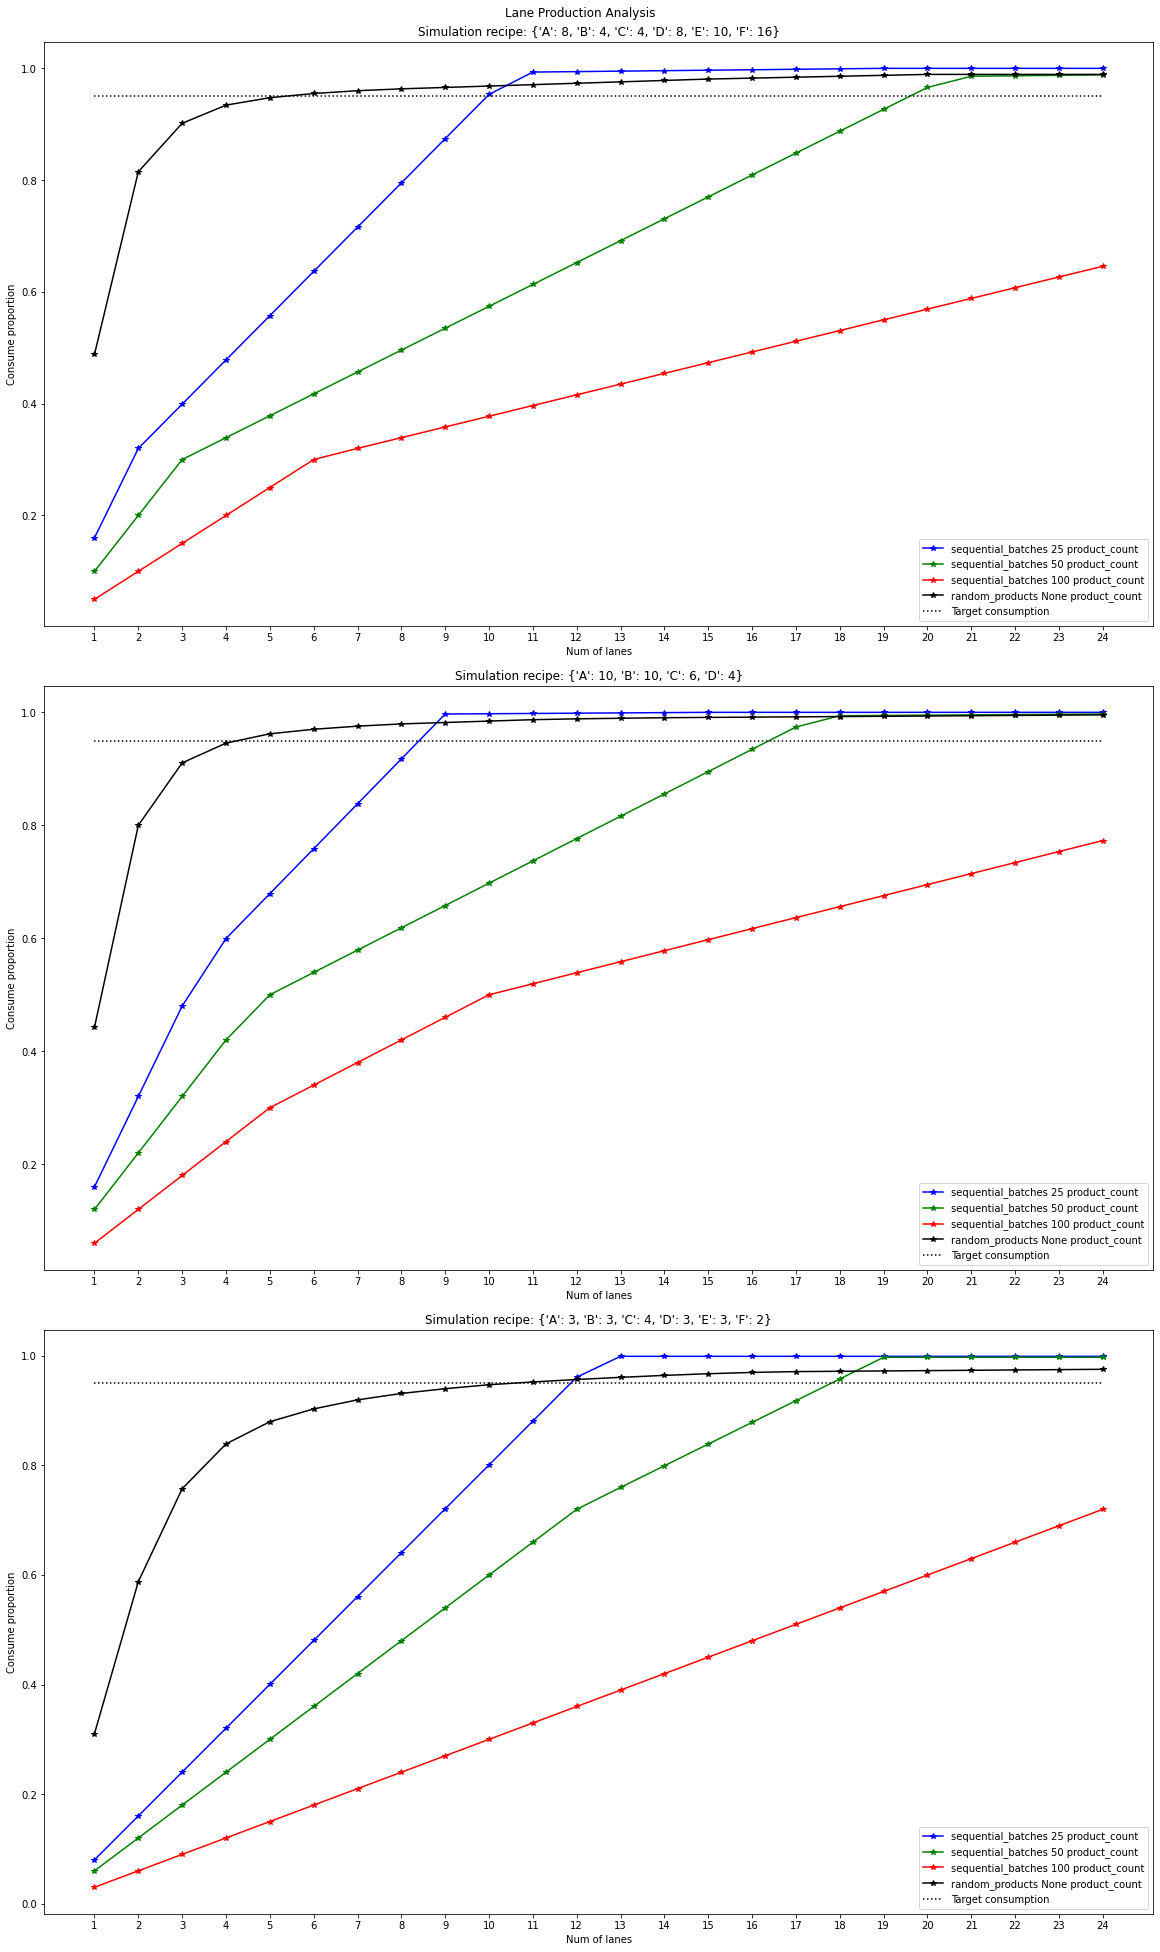

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, axs = plt.subplots(
    len(recipes), figsize=(16, 9 * len(recipes)), constrained_layout=True
)

fig.suptitle("Lane Production Analysis")

color_map = defaultdict(lambda: "k")
for batch_size, color in zip(batch_sizes, mcolors.BASE_COLORS.keys()):
    color_map[batch_size] = color

line_type_map = defaultdict(lambda: "-")

xx = list(range(1, 25))

for (recipe_index, infeed_type, batch_size), infeed in infeeds.items():
    color = color_map[batch_size]
    line_type = line_type_map[infeed_type]

    if infeed_type in ["random_products", "sequential_batches"]:
        yy = get_the_ys(xx, recipes[recipe_index], infeed)
        axs[recipe_index].plot(
            xx,
            yy,
            f"{line_type}{color}",
            marker="*",
            label=f"{infeed_type} {batch_size} product_count",
        )

for recipe_index, recipe in enumerate(recipes):
    zz = np.ones(len(xx)) * 0.95
    axs[recipe_index].plot(xx, zz, f":k", label=f"Target consumption")
    axs[recipe_index].set_xticks(xx)
    axs[recipe_index].legend()
    axs[recipe_index].set_title(f"Simulation recipe: {recipe_maps[recipe_index]}")
    axs[recipe_index].set_xlabel("Num of lanes")
    axs[recipe_index].set_ylabel("Consume proportion")

plt.show()

In [13]:
batch_size = 50
num_of_lanes = 5

In [14]:
def create_subplot(recipe_index, infeed_type, batch_size=None):
    infeed = infeeds[(recipe_index, infeed_type, batch_size)]
    recipe = recipes[recipe_index]
    
    data = simulate_fast(num_of_lanes, recipe, infeed, lane_lock)

    for lane in range(len(data[3])):
        production = data[3][lane,:]
        arrays = np.array_split(
            production, range(products_per_min, len(production), products_per_min)
        )
        y = [a.sum() for a in arrays]
        axs[recipe_index].plot([0] + y, label=f"Lane {lane}")

    # combine all lanes
    x = data[3].sum(axis=0)
    arrays = np.array_split(x, range(products_per_min, len(x), products_per_min))
    y = [a.sum() for a in arrays]
    axs[recipe_index].plot([0] + y, label=f"All lanes")

    # optimality lines
    optimal_boxes_per_min = products_per_min / sum(recipe)
    optimal_boxes_per_min_per_lane = optimal_boxes_per_min / num_of_lanes
    axs[recipe_index].plot(
        [optimal_boxes_per_min] * (len(y) + 1), f":k", label=f"optimal_boxes_per_min"
    )
    axs[recipe_index].plot(
        [optimal_boxes_per_min_per_lane] * (len(y) + 1),
        f"-.k",
        label=f"optimal_boxes_per_min",
    )
    axs[recipe_index].legend()
    axs[recipe_index].set_title(f"Simulation recipe: {recipe_maps[recipe_index]}")
    axs[recipe_index].set_xlabel("Minutes")
    axs[recipe_index].set_ylabel("Boxes produced")

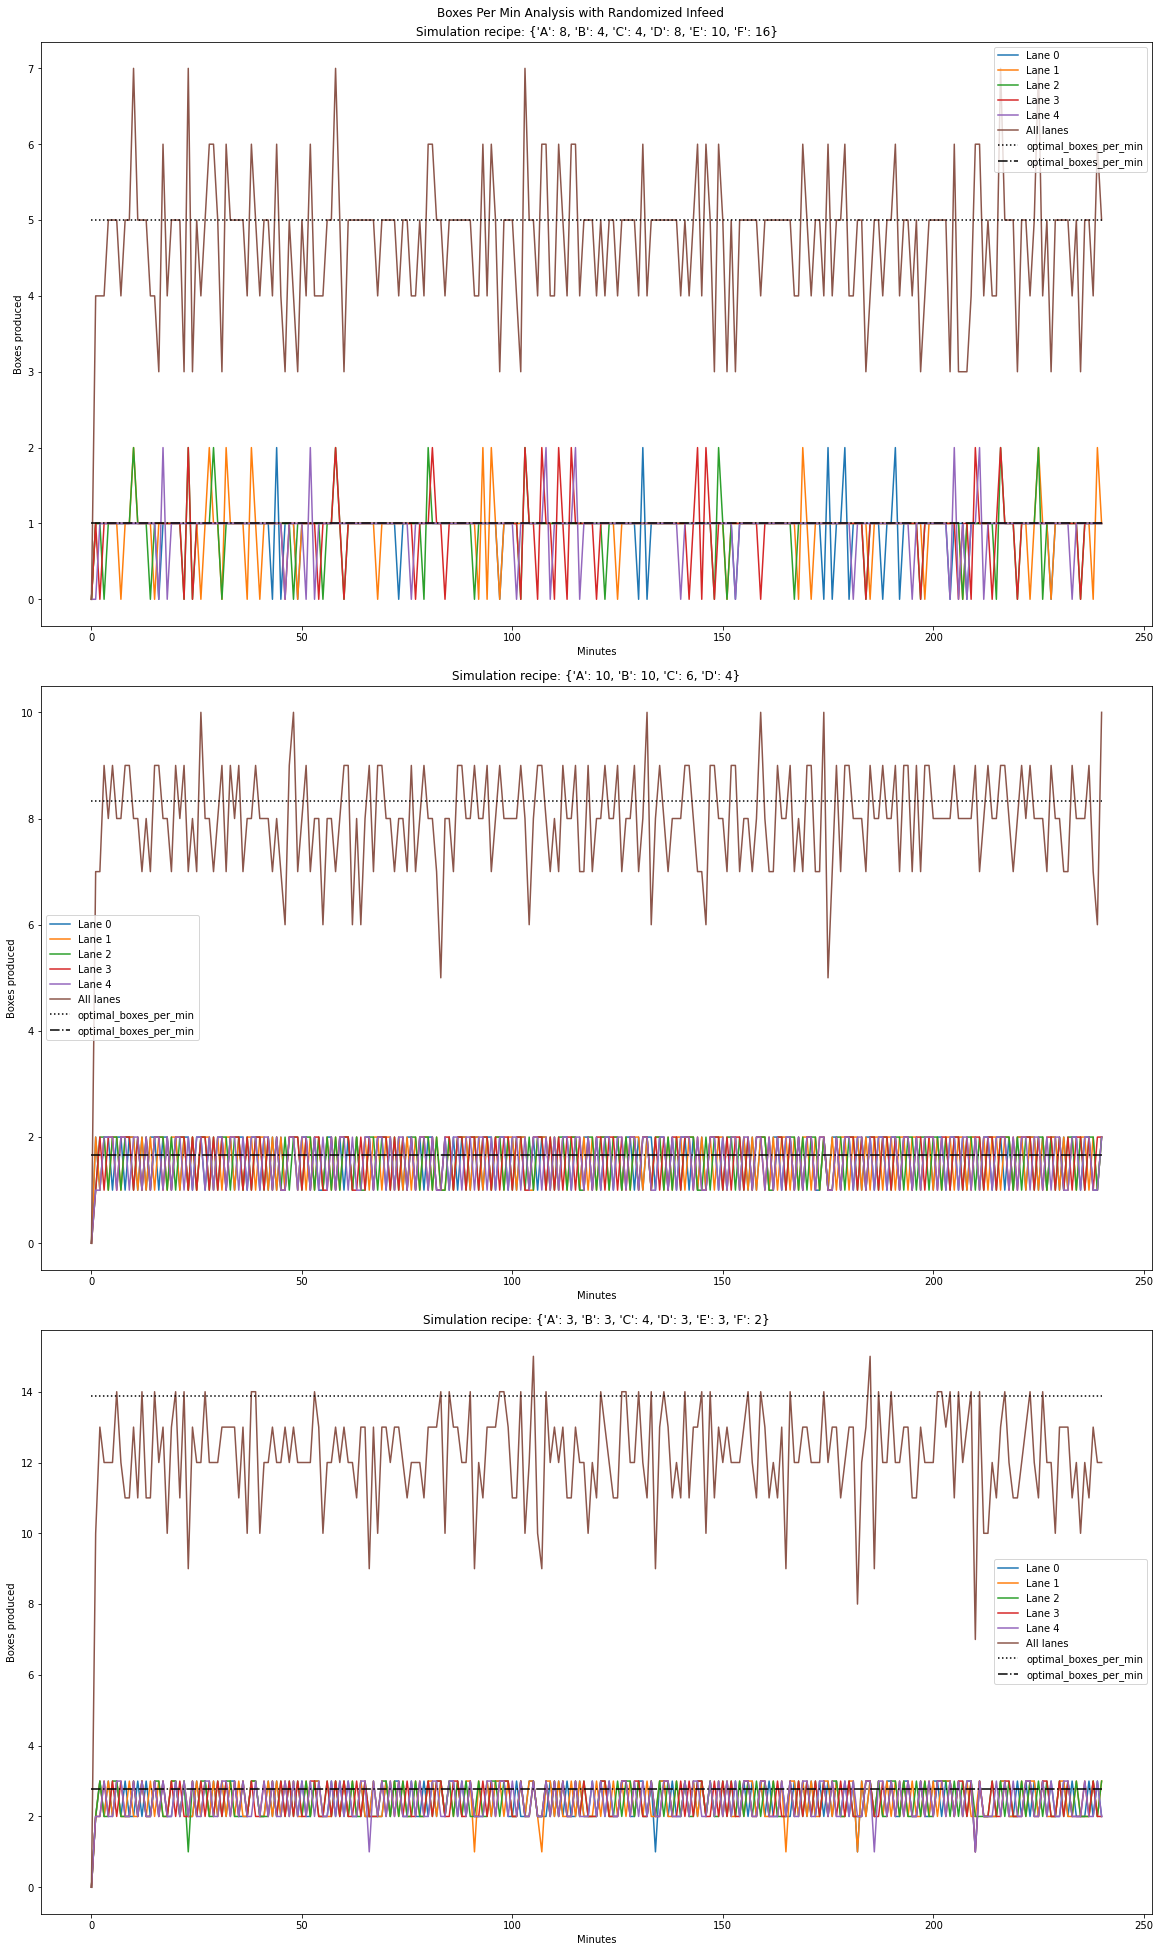

In [15]:
fig, axs = plt.subplots(
    len(recipes), figsize=(16, 9 * len(recipes)), constrained_layout=True
)

fig.suptitle("Boxes Per Min Analysis with Randomized Infeed")

for recipe_index, recipe in enumerate(recipes):
    create_subplot(recipe_index, "random_products")

plt.show()

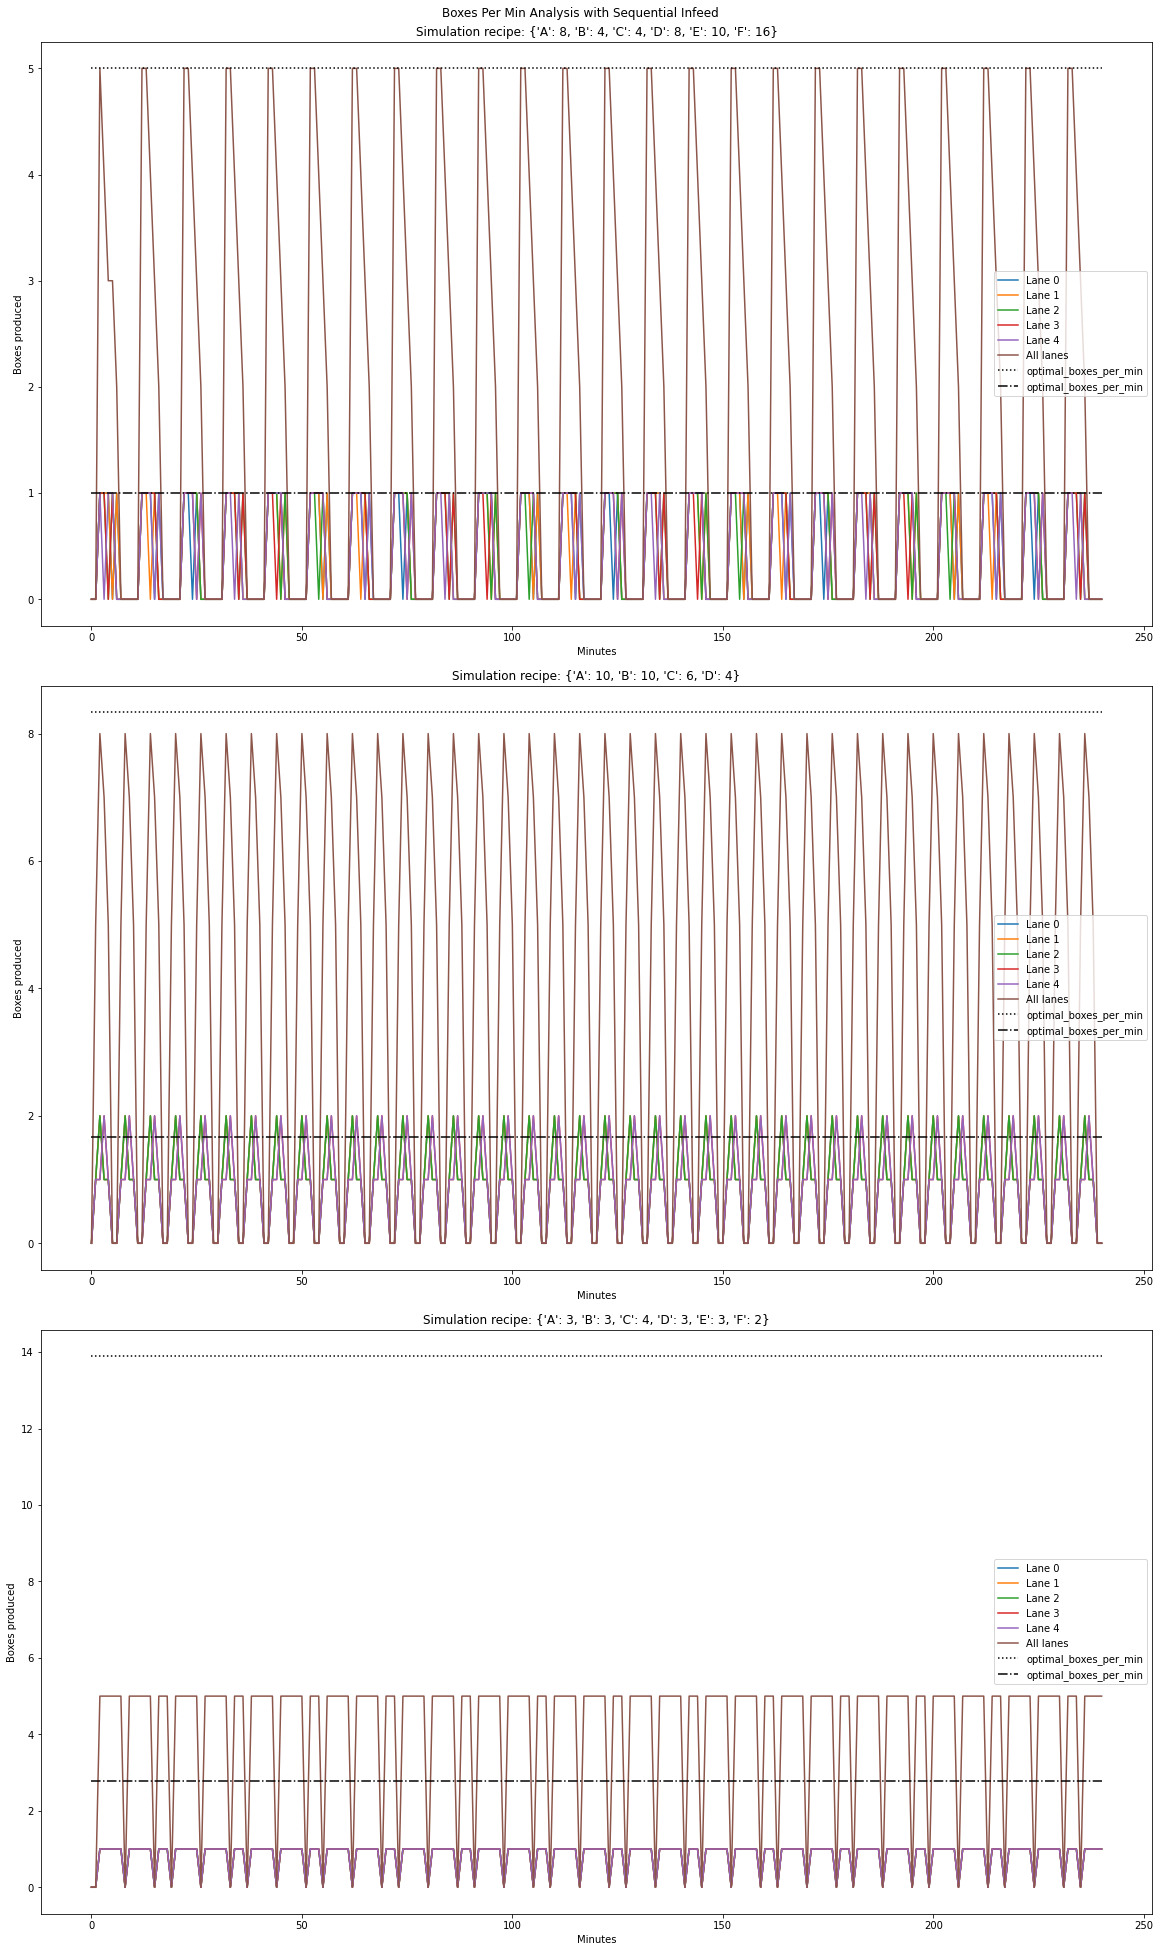

In [16]:
fig, axs = plt.subplots(
    len(recipes), figsize=(16, 9 * len(recipes)), constrained_layout=True
)

fig.suptitle("Boxes Per Min Analysis with Sequential Infeed")

for recipe_index, recipe in enumerate(recipes):
    create_subplot(recipe_index, "sequential_batches", batch_size=batch_size)

plt.show()

In [17]:
def avg_consumption_rate(x_num_of_lanes, y_lane_lock, infeed_type, batch_size=None):
    x, y = np.meshgrid(x_num_of_lanes, y_lane_lock)

    I, J = y.shape

    data = []
    
    for recipe_index in range(len(recipes)):
        z_arrays = []

        for i in range(I):
            lane_lock = y[i, 0]
            infeed = infeeds[(recipe_index, infeed_type, batch_size)]
            recipe = recipes[recipe_index]
            z_arrays.append(get_the_ys(x[i, :], recipe, infeed, lane_lock))

        data.append(np.array(z_arrays))

    tensor = np.array(data)
    
    return tensor.mean(axis=0)

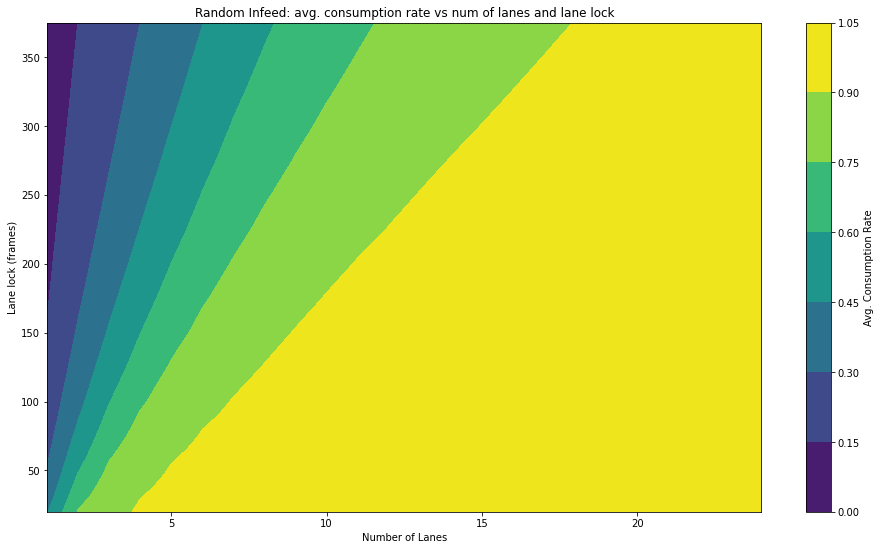

In [18]:
plt.figure(figsize=(16, 9))

x_num_of_lanes = list(range(1, 25))
# x_num_of_lanes = list(range(1, 6))
y_lane_lock = list(range(20, 100, 5)) + list(range(100, 400, 25))
# y_lane_lock = list(range(20, 100, 20))
z_avg_consumption_rate = avg_consumption_rate(x_num_of_lanes, y_lane_lock, "random_products") 

plt.contourf(x_num_of_lanes, y_lane_lock, z_avg_consumption_rate, vmin=0, vmax=1)
plt.colorbar(label="Avg. Consumption Rate")

plt.title(f"Random Infeed: avg. consumption rate vs num of lanes and lane lock")
plt.ylabel("Lane lock (frames)")
plt.xlabel("Number of Lanes")

plt.show()

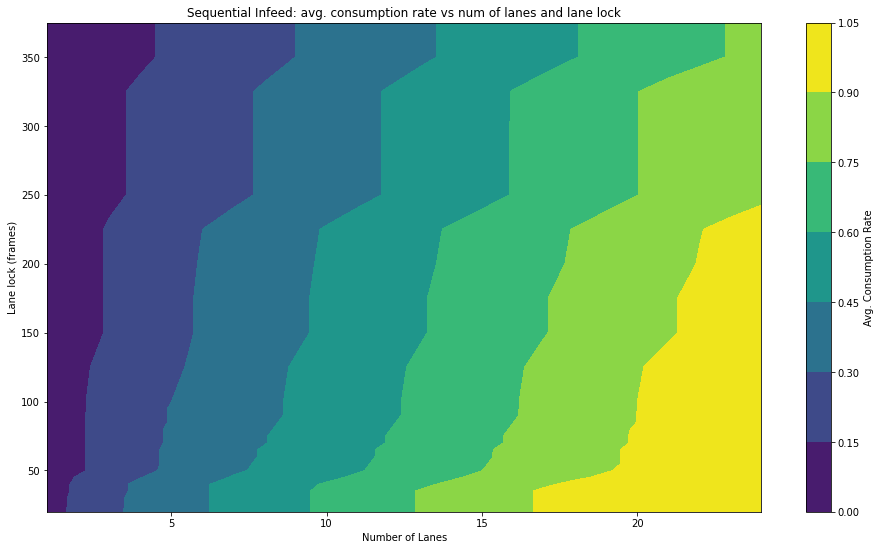

In [19]:
plt.figure(figsize=(16, 9))

x_num_of_lanes = list(range(1, 25))
# x_num_of_lanes = list(range(1, 6))
y_lane_lock = list(range(20, 100, 5)) + list(range(100, 400, 25))
# y_lane_lock = list(range(20, 100, 20))
z_avg_consumption_rate = avg_consumption_rate(x_num_of_lanes, y_lane_lock, "sequential_batches", 50) 

plt.contourf(x_num_of_lanes, y_lane_lock, z_avg_consumption_rate, vmin=0, vmax=1)
plt.colorbar(label="Avg. Consumption Rate")

plt.title(f"Sequential Infeed: avg. consumption rate vs num of lanes and lane lock")
plt.ylabel("Lane lock (frames)")
plt.xlabel("Number of Lanes")

plt.show()

In [20]:
import string


def generate_random_recipes(
    num_of_recipes, min_num_of_products, max_num_of_products, lower, upper
):
    recipes = []
    for r in range(num_of_recipes):
        recipe = {}

        for product in string.ascii_uppercase[
            : np.random.randint(min_num_of_products, high=max_num_of_products)
        ]:
            recipe[product] = np.random.randint(lower, high=upper)

        recipes.append(recipe)

    return recipes

In [21]:
recipe_maps = generate_random_recipes(80, 3, 6, 2, 16)
recipes = [np.asarray(list(m.values())) for m in recipe_maps]
recipes[:5]

[array([14,  6,  2]),
 array([5, 5, 9]),
 array([ 5,  4, 12,  5]),
 array([5, 8, 9]),
 array([ 3, 13,  8,  4])]

In [22]:
infeeds = create_infeed_types()

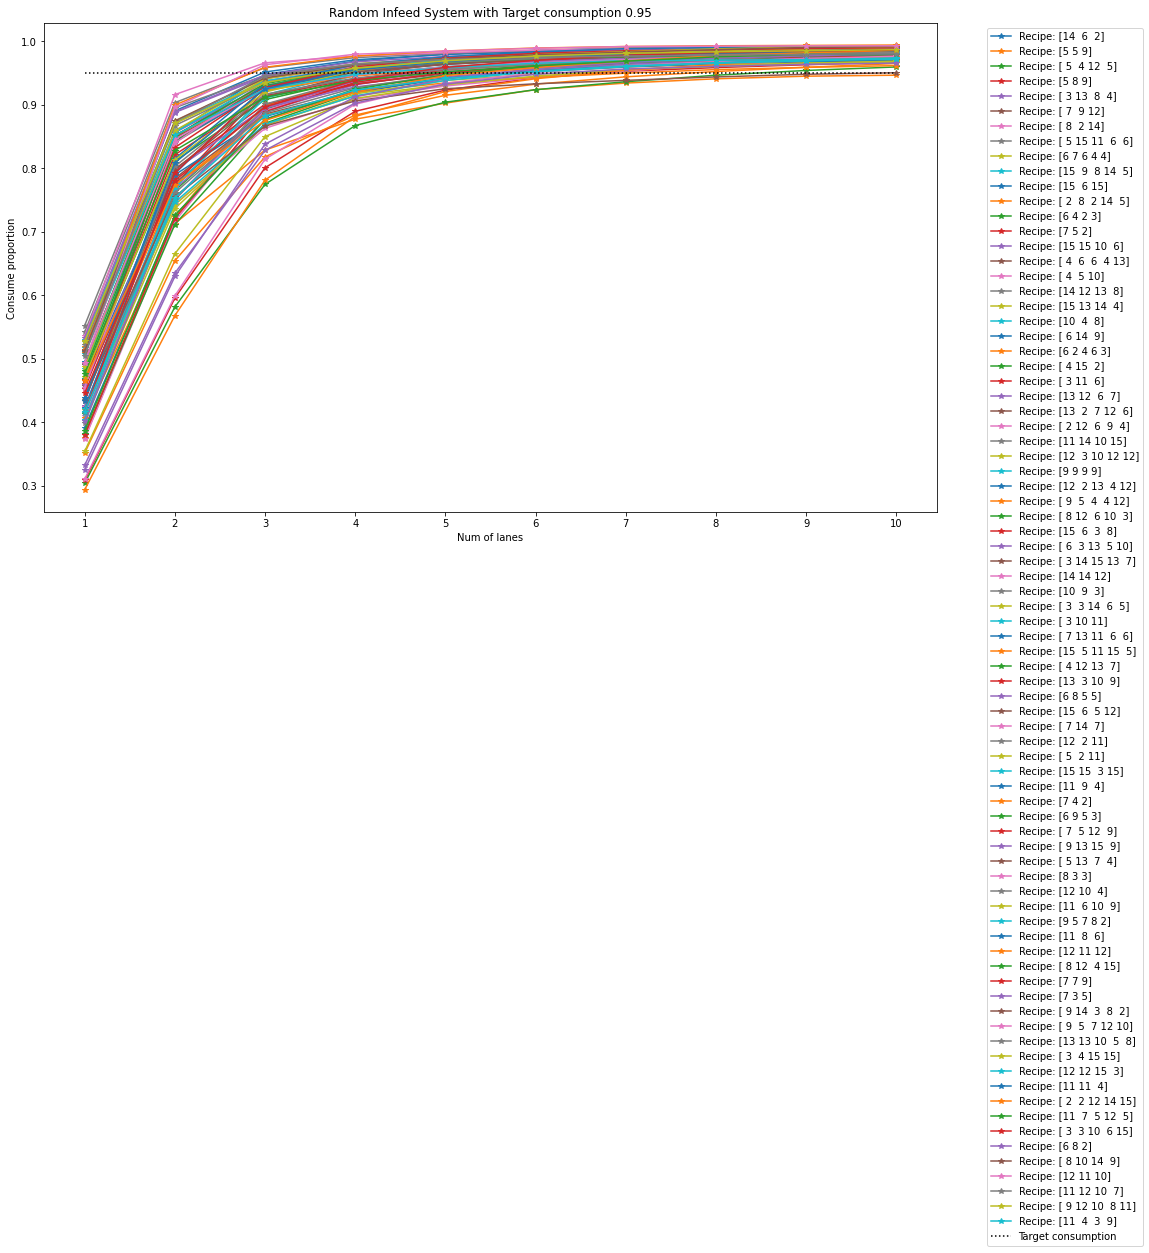

In [23]:
plt.figure(figsize=(16, 9))

xx = list(range(1, 11))
arrays = []
for recipe_index, recipe in enumerate(recipes):
    infeed = infeeds[(recipe_index, "random_products", None)]
    yy = get_the_ys(xx, recipe, infeed)
    arrays.append(yy)
    plt.plot(xx, yy, marker="*", label=f"Recipe: {recipe}")

target_consumption = 0.95
zz = np.ones(len(xx)) * target_consumption
plt.plot(xx, zz, f":k", label=f"Target consumption")

plt.xticks(xx)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")

plt.title(f"Random Infeed System with Target consumption {target_consumption}")
plt.xlabel("Num of lanes")
plt.ylabel("Consume proportion")

plt.show()

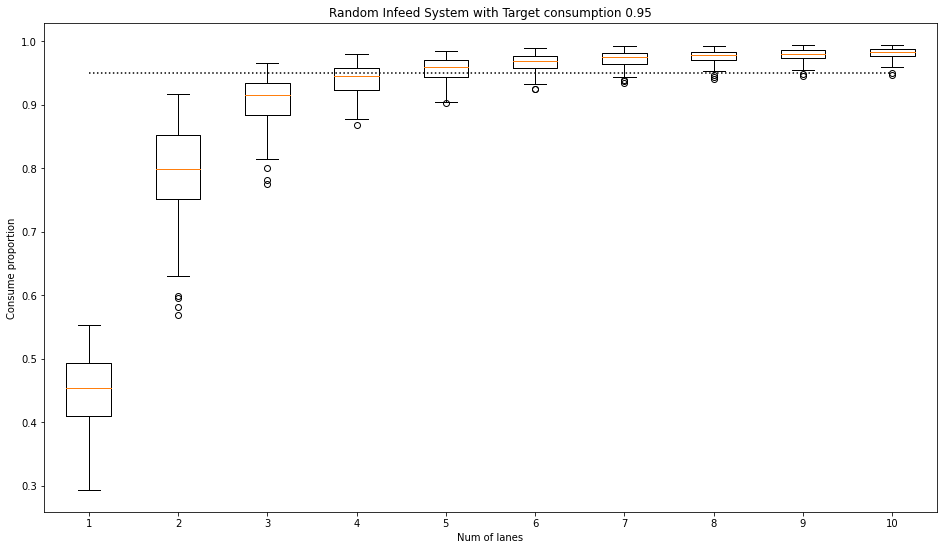

In [24]:
plt.figure(figsize=(16, 9))

plt.boxplot(np.array(arrays))

zz = np.ones(len(xx)) * target_consumption
plt.plot(xx, zz, ":k")

plt.title(f"Random Infeed System with Target consumption {target_consumption}")
plt.xlabel("Num of lanes")
plt.ylabel("Consume proportion")

plt.show()